In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats
from scipy.stats import ttest_ind
import datetime
import json
import seaborn as sns
from sklearn.feature_extraction import image
import imageio
import nltk
from nltk.corpus import stopwords
import os
from pylab import *
from zipfile import *
from PIL import Image
#nltk.download()


In [3]:
#reading
original=pd.read_json("train.json.zip")


## Exploratory 

In [4]:
df=original
df['created'] = df['created'].astype('datetime64[ns]')
df['created_hour']=df['created'].dt.hour
df["location"] = list(zip(df["latitude"].values,df.longitude.values))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B265984DD8>,
      dtype=object)

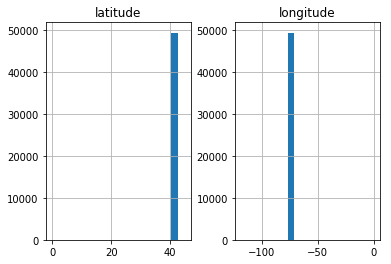

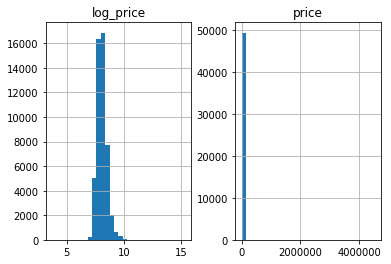

In [5]:
#hist = df.hist(bins = 100)
df["log_price"]=np.log(df.price)
df.hist(column = ["latitude","longitude"],bins=20)
df.hist(column = ["price","log_price"],bins=30)
#the histogram graphs aren't normal because some values are defaulted to 0 if left empty 
#and most values are relatively similar

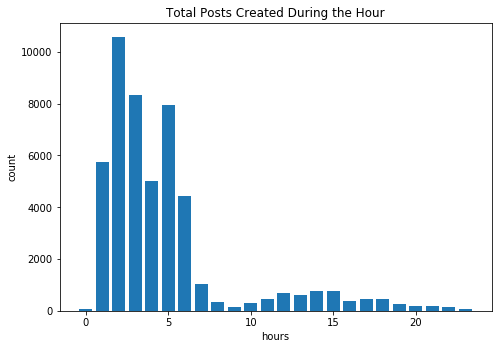

In [6]:
hours=df.groupby(['created_hour']).count()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(hours.index,hours["bedrooms"])
plt.xlabel("hours")
plt.ylabel("count")
plt.title("Total Posts Created During the Hour")
plt.show()
#in order of most posts created: 2, 3, 5, 1, 4

#a possible explanation for the curve:the date time column may not be consistent
#don't know if the system is always using a 24hr clock or AM/PM

### More pre-processing visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B26596A208>,
      dtype=object)

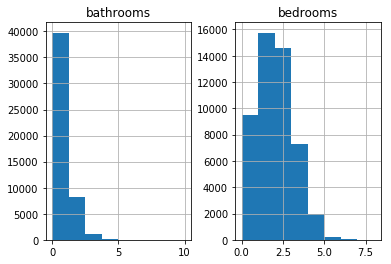

In [7]:
df.hist(column = ["bedrooms","bathrooms"],bins=8)
#bedroom is relatively normal while bathroom is right skewed
#but zscore outlier method will be used for both because the max/min values are relatively close to the mean


Text(0.5, 1.0, 'Coordinate Map of the Data Points')

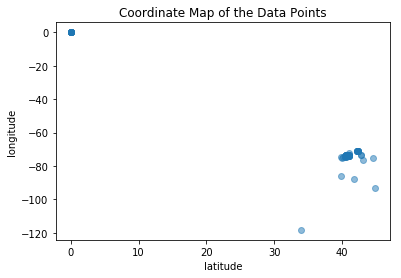

In [8]:
plt.scatter(df.latitude,df.longitude,alpha=0.5)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Coordinate Map of the Data Points")

#### Quick visualizations with target variable (interest level)

In [9]:
#instead of using low/med/high, we'll represent the interest level with 1,2,3 respectively
def interests(level):
    if level == "low":
        return 1
    elif level == "medium":
        return 2
    elif level == "high":
        return 3
df["interest"]=df["interest_level"].apply(interests)

In [10]:
#just swapping 2 records so interest_level appears low,med,high for first 3 records
temp = df.iloc[0]
df.iloc[0]=df.iloc[1]
df.iloc[1]=temp

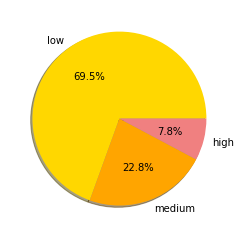

In [11]:
distribution=df.interest_level.value_counts()
labsl = "low", "medium", "high"
colors = ['gold', 'orange', 'lightcoral']
plt.pie(distribution,autopct='%1.1f%%',shadow = True, labels = labsl, colors= colors)
plt.show()

Text(0.5, 1.0, 'Logged Prices of the Interest Levels')

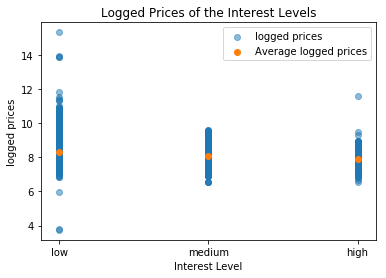

In [12]:
avg_price = df.groupby(["interest_level"]).mean()
plt.scatter(df.interest_level,np.log(df.price),alpha = 0.5)
plt.scatter(avg_price.index,np.log(avg_price.price))
plt.legend(["logged prices","Average logged prices"])
plt.xlabel("Interest Level")
plt.ylabel("logged prices")
plt.title("Logged Prices of the Interest Levels")

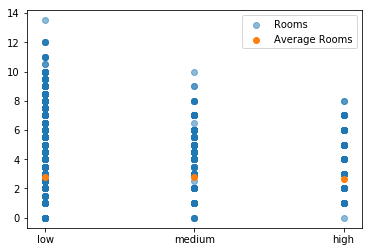

In [13]:
df["rooms"]=df.bathrooms+df.bedrooms
avg_room = df.groupby(["interest_level"]).mean()
plt.scatter(df.interest_level,df.rooms, alpha = 0.5)
plt.scatter(avg_room.index,avg_room.rooms)
plt.legend( ["Rooms","Average Rooms"])

Text(0.5, 1.0, 'Average Interest Level of Most Popular Neighbourhoods')

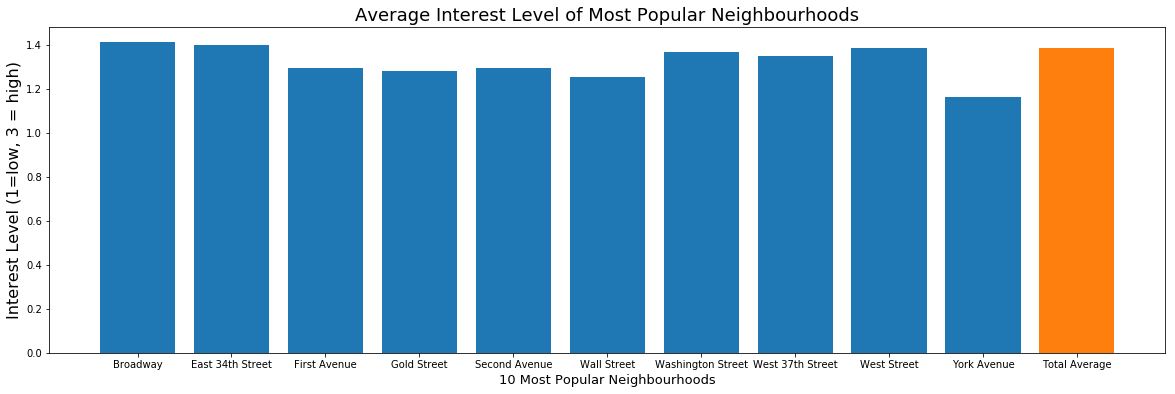

In [14]:
popular=df.display_address.value_counts()[:10].index.values
pop=df[df.display_address.isin(popular)]
pop=pop.groupby(["display_address"]).mean()
avg = df.interest.mean()
plt.figure(figsize=(20,6))
plt.bar(pop.index,pop.interest)
plt.bar("Total Average",avg)
plt.xlabel("10 Most Popular Neighbourhoods",fontsize = 13)
plt.ylabel("Interest Level (1=low, 3 = high)", fontsize = 16)
plt.title("Average Interest Level of Most Popular Neighbourhoods", fontsize =18)

## Outliers/Missing Values
### Missing values are either empty strings or defaulted to the value 0

In [15]:
#missing values for bedroom/bathrooms
#difficult to know if an apartment actually has 0 bathrooms or 0 bedrooms or it's just default value
#assume it's missing value if both bathroom and bedroom has value of 0
#df[(df["bedrooms"]==0) &  ( df["bathrooms"]==0)].shape[0]

In [16]:
#no missing values for date as they're all within expected time frame
print(df["created"].min())
print(df["created"].max())

2016-04-01 22:12:41
2016-06-29 21:41:47


In [17]:
#although 0 is a valid longitude and latitude, we'll assume it is a missing value if it's exactly 0
#
print("bedroom ",df[df["bedrooms"]==0].shape[0])
print("bathroom ",df[df["bathrooms"]==0].shape[0])
print("building id ",df[df["building_id"]=="0"].shape[0])
print("description ",df[df["description"]==""].shape[0])
print("display add ",df[df["display_address"]==""].shape[0])
print("features ", df[df["features"].str.len()==0].shape[0])
print("lat ",df[df["latitude"]==0].shape[0])
print("listing id ", df[df["listing_id"]==0].shape[0])
print("lon ",df[df["longitude"]==0].shape[0])
#no missing value for manager_id
print("manager id missing values: ",df[df["manager_id"]==""].shape[0])
print("photos with no link:", df[df["photos"].str.len() == 0].shape[0])
print("price missing values:", df[df["price"]==0].shape[0])
print("street address missing values:", df[df["street_address"]==""].shape[0])
print("missing value for interest level:", df[df["interest_level"]==""].shape[0])

bedroom  9475
bathroom  313
building id  8286
description  1446
display add  135
features  3218
lat  12
listing id  0
lon  12
manager id missing values:  0
photos with no link: 3615
price missing values: 0
street address missing values: 10
missing value for interest level: 0


In [18]:
#outlier for interst level if it isn't one of the 3 categories
print(df[(df["interest_level"] != "medium") & (df["interest_level"] != "high") & (df["interest_level"] != "low")].shape[0])

0


### outlier

In [19]:
#too difficult for my computer to run the whole thing, so i split it 
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = 2,
  min_samples = 5)
clusters = outlier_detection.fit(df[["longitude","latitude"]].iloc[:25000])
lab1=clusters.labels_
clusters2 = outlier_detection.fit(df[["longitude","latitude"]].iloc[25000:])
lab2=clusters2.labels_


In [20]:
df["loc_out"]=np.concatenate([lab1,lab2])
#set all normal points to the same colour
def nonoutlier(x):
    if x >-1:
        x = 0
    return x
df["loc_out"] = df['loc_out'].apply(nonoutlier)

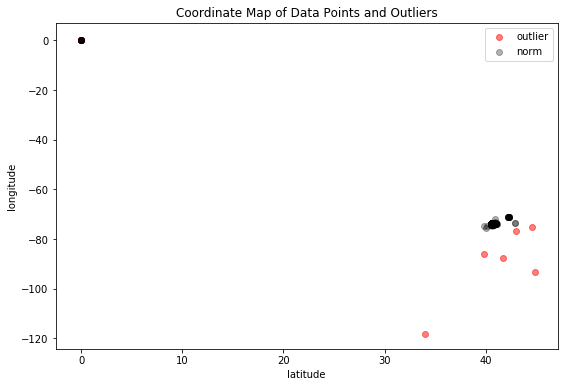

10

In [21]:
plt.figure(figsize=(9,6))
plt.scatter(df.latitude[df.loc_out==-1],df.longitude[df.loc_out==-1], alpha=0.5,c="red")
plt.scatter(df.latitude[df.loc_out==0],df.longitude[df.loc_out==0], alpha=0.3, c="black")
plt.legend(["outlier","norm"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Coordinate Map of Data Points and Outliers")
plt.show()
df[df.loc_out==-1].shape[0]

#### Outlier detection for price, bathrooms, bedrooms

In [22]:
Q1 = df.price.quantile(0.25)
Q2 = df.price.quantile(0.50)
Q3 = df.price.quantile(0.75)
IQR = Q3 - Q1

In [23]:
#usually it's 1.5*IQR but that detects lots of valid points as outliers
price_out=(df.price < (Q1 - 1.5 * IQR)) |(df.price > (Q3 + 6 * IQR)) 
df[price_out].shape[0]

431

Text(0.5, 1.0, 'Outliers of Price Feature')

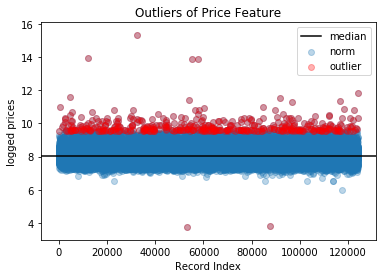

In [24]:
plt.scatter(df.index,np.log(df.price), alpha=0.3)
plt.axhline(y=np.log(Q2), color="black", linestyle='-') #median
plt.scatter(df.index[price_out],np.log(df.price[price_out]),alpha=0.3,c="red")
plt.legend(["median","norm","outlier"])
plt.xlabel("Record Index")
plt.ylabel("logged prices")
plt.title("Outliers of Price Feature")

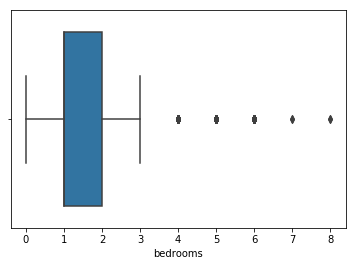

In [25]:
sns.boxplot(x=df['bedrooms'])

In [26]:
#Under normal curve, 99.7% of data lies within 3 std dev of the mean
#bathrooms distribution is a bit right skewed so we have 2% detected as outliers which is more than we want
#so we modify it to 4*std dev of mean which is any apartment with more than 3 washrooms is an outlier
bath_out = df.bathrooms>df.bathrooms.mean()+4*df.bathrooms.std()

In [27]:
df[bath_out].shape

(290, 21)

Text(0.5, 1.0, 'Scatterplot of Bedrooms')

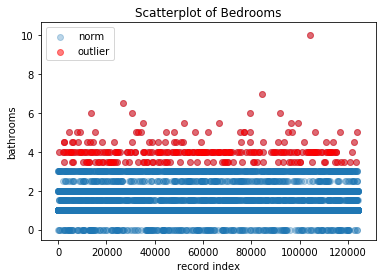

In [28]:
plt.scatter(df.index,(df.bathrooms),alpha=0.3)

plt.scatter(df.index[bath_out],(df.bathrooms[bath_out]),c="red", alpha = 0.5)
plt.ylabel("bathrooms")
plt.legend(["norm","outlier"])
plt.xlabel("record index")
plt.title("Scatterplot of Bedrooms")

In [29]:
bed_out = df.bedrooms > df.bedrooms.mean()+3*df.bedrooms.std()

Text(0.5, 1.0, 'Scatterplot of Bathrooms')

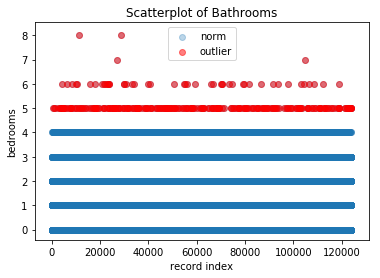

In [30]:
#5 or more bedrooms will be the outlier

plt.scatter(df.index,(df.bedrooms),alpha = 0.3)
plt.scatter(df.index[bed_out],(df.bedrooms[bed_out]),c="red", alpha = 0.5)
plt.ylabel("bedrooms")
plt.legend(["norm","outlier"])
plt.xlabel("record index")
plt.title("Scatterplot of Bathrooms")

In [31]:
df[bed_out].shape[0]

297

In [32]:
#removing outlier records
original_record_num=df.shape[0]
df.drop(df[bed_out].index,inplace=True)
df.drop(df[bath_out].index,inplace=True)
df.drop(df[price_out].index,inplace=True)
df.drop(df[df.loc_out==-1].index,inplace=True)
df.drop(df[df.latitude ==0].index,inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


#### Imputation

In [33]:
#set "missing values" as NaN 
(df.bedrooms[df.bedrooms==0])= np.nan
(df["bathrooms"][df.bathrooms==0])= np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
#linear regression imputation
index = df.index
df.set_index('price', inplace=True)
df['bedrooms'].interpolate(method='linear', inplace=True, limit_direction="both")
df['bathrooms'].interpolate(method='linear', inplace=True, limit_direction="both")
df.reset_index(inplace=True)
df.index=index

In [35]:
df.display_address[df["display_address"]==""]=df.street_address
#there will be 10 more rows with missing addresses, so we'll just drop those 10
df.drop(df[df["display_address"]==""].index,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
#drop building id because there are lots of missing values, the values aren't interpretable for a human
#don't think bulding id or manager id is a good feature for predicting property popularity
#because there is no order to it (not categorical nor continuous)
#drop street_address because display_address is similar and sufficient in giving the neighbourhood
df=df.drop(columns = ["building_id", "street_address","manager_id"])

#dropping columns created during transformation
df=df.drop(columns=["loc_out","rooms","log_price","location","created_hour"])

### Feature Extraction of Images

In [37]:
imageZip = ZipFile('images_sample.zip')
imageZip.extractall()

In [38]:
for file in imageZip.namelist():
    if file.endswith('.jpg'):
        b = os.path.split(os.path.split(file)[0])[1]
       # print(b)
        img = Image.open(file)
        greyscale = img.convert('L')
        mgrey = mean(np.array(greyscale))
      #  print(mgrey)
        tempdf = pd.DataFrame([[b,mgrey]],columns=['listing_id','greyscale_means'])
      #  df2 = pd.concat([df2,tempdf],sort=False)
    

### Feature Extraction of Text

In [39]:
#features and descriptions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

textFeatures = df[['features', 'description', 'interest_level']]
# print(textFeatures.iloc[0])
#textFeatures

In [40]:
# featuresBoW = textFeatures['features'].apply(lambda x: x.split(' '))
descBoW = textFeatures.description.str.split()
# print(descBoW)
textFeatures['description'] = descBoW
textFeatures['description']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


10                                                       []
10000     [A, Brand, New, 3, Bedroom, 1.5, bath, Apartme...
100004    [Top, Top, West, Village, location,, beautiful...
100007    [Building, Amenities, -, Garage, -, Garden, -,...
100013    [Beautifully, renovated, 3, bedroom, flex, 4, ...
100014                                                   []
100016    [Stunning, unit, with, a, great, location, and...
100020    [This, huge, sunny, ,plenty, of, lights, 1, be...
100026                            [<p><a, website_redacted]
100027    [This, is, a, spacious, four, bedroom, with, e...
100030    [New, to, the, market!, Spacious, studio, loca...
10004     [Check, out, this, one, bedroom, apartment, in...
100044    [***LOW, FEE., Beautiful, CHERRY, OAK, WOODEN,...
100048    [Lincoln, Square's, premier, full, service, bu...
10005     [Spacious, 1-Bedroom, to, fit, King-sized, bed...
100051    [Stunning, full, renovated, studio, unit., Hig...
100052    [East, Village, is, a, great, 

In [41]:
# textFeatures['features'].to_string(textFeatures['test'])
textFeatures['features'] = textFeatures['features'].astype(str)
# textFeatures['features'] = textFeatures['features'].str.join('')
#textFeatures
# print(textFeatures['features'].iloc[0])
# print(textFeatures)
# textFeatures['features'].dtype
stop = stopwords.words('english')
# textFeatures['description'] = textFeatures['description'].apply(lambda x: [word for word in x if word not in stop])
textFeatures['description'] = textFeatures['description'].apply(lambda x: [''.join(letter for letter in word if letter.isalnum()) for word in x])
textFeatures['description'] = textFeatures['description'].astype(str)
print(textFeatures)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


                                                 features  \
10      ['Doorman', 'Elevator', 'Fitness Center', 'Cat...   
10000                                                  []   
100004  ['Laundry In Building', 'Dishwasher', 'Hardwoo...   
100007                      ['Hardwood Floors', 'No Fee']   
100013                                        ['Pre-War']   
100014                                                 []   
100016  ['prewar', 'elevator', 'Dogs Allowed', 'Cats A...   
100020  ['Doorman', 'Elevator', 'Pre-War', 'Terrace', ...   
100026  ['Cats Allowed', 'Dogs Allowed', 'Elevator', '...   
100027                  ['Dishwasher', 'Hardwood Floors']   
100030                                                 []   
10004   ['prewar', 'dishwasher', 'HIGHRISE', 'ROOFDECK...   
100044  ['Doorman', 'Elevator', 'Laundry in Building',...   
100048  ['Swimming Pool', 'Doorman', 'Fitness Center',...   
10005   ['Elevator', 'Multi-Level', 'Laundry in Buildi...   
100051  ['Doorman', 'Ele

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [42]:
vectorizer = TfidfVectorizer(max_features=50)
# vectorizer.fit(textFeatures['features'])
# textFeatures['features_idf'] = textFeatures['features'].apply(lambda x: vectorize(x, vectorizer))
x = vectorizer.fit_transform(textFeatures['features'])
x.toarray().shape
first_vector = x[0]
tfidf = pd.DataFrame(first_vector.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
tfidf.sort_values(by=["tfidf"],ascending=False)
x = x.toarray().tolist()

# print(vectorizer.vocabulary_)
# print(vectorizer.idf_)
# x = x.toarray()
# x
# textFeatures['idf'] = x
# print(textFeatures['idf'])

In [43]:
textFeatures['features_idf'] = x
#textFeatures[['features', 'features_idf']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
vectorizer = TfidfVectorizer(max_features=50)
y = vectorizer.fit_transform(textFeatures['description'])
y.toarray().shape
y = y.toarray()
textFeatures['description_idf'] = textFeatures['description'].apply(lambda x: vectorize(x, vectorizer))

ValueError: Invalid otype specification

In [54]:
y = np.stack(y)
y
textFeatures['description_idf'] = y

#textFeatures['description_idf']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
df["features"]=textFeatures["features"]
df["description"]=textFeatures["description"]
df["features_idf"]=textFeatures["features_idf"]
df["description_idf"]=textFeatures["description_idf"]

## some new features for model training

In [47]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_desc"] = df["description"].apply(len)
df["day_of_week"]=df.created.dt.dayofweek

In [55]:
df.to_json('train_ETL.json.gz', compression='gzip')
#read with pd.read_csv("train_ETL.csv.gz")

In [56]:
df

,price,bathrooms,bedrooms,created,description,display_address,features,latitude,listing_id,longitude,photos,interest_level,interest,features_idf,description_idf,num_photos,num_features,num_desc,day_of_week
10,5465,1.0,2.0,2016-06-12 12:19:27,[],Columbus Avenue,"['Doorman', 'Elevator', 'Fitness Center', 'Cat...",40.7947,7150865,-73.9667,[https://photos.renthop.com/2/7150865_be3306c5...,low,1,"[0.0, 0.5851074667834789, 0.0, 0.0, 0.29308358...",,11,73,2,6
10000,3000,1.5,3.0,2016-06-24 07:54:24,"['A', 'Brand', 'New', '3', 'Bedroom', '15', 'b...",Metropolitan Avenue,[],40.7145,7211212,-73.9425,[https://photos.renthop.com/2/7211212_1ed4542e...,medium,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0, 30)\t0.1776163821148241\n (0, 8)\t0.167...",5,2,823,4
100004,2850,1.0,1.0,2016-04-17 03:26:41,"['Top', 'Top', 'West', 'Village', 'location', ...",W 13 Street,"['Laundry In Building', 'Dishwasher', 'Hardwoo...",40.7388,6887163,-74.0018,[https://photos.renthop.com/2/6887163_de85c427...,high,3,"[0.0, 0.3672803019787415, 0.0, 0.4164003778182...","(0, 30)\t0.1420402417973664\n (0, 8)\t0.134...",8,85,911,6
100007,3275,1.0,1.0,2016-04-18 02:22:02,"['Building', 'Amenities', '', 'Garage', '', 'G...",East 49th Street,"['Hardwood Floors', 'No Fee']",40.7539,6888711,-73.9677,[https://photos.renthop.com/2/6888711_6e660cee...,low,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0, 3)\t0.070735125312101\n (0, 36)\t0.1840...",3,29,647,0
100013,3350,1.0,4.0,2016-04-28 01:32:41,"['Beautifully', 'renovated', '3', 'bedroom', '...",West 143rd Street,['Pre-War'],40.8241,6934781,-73.9493,[https://photos.renthop.com/2/6934781_1fa4b41a...,low,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0, 8)\t0.23775749541087743\n (0, 3)\t0.322...",3,11,669,3
100014,7995,2.0,4.0,2016-04-19 04:24:47,[],West 18th Street,[],40.7429,6894514,-74.0028,[https://photos.renthop.com/2/6894514_9abb8592...,medium,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,5,2,2,1
100016,3600,1.0,2.0,2016-04-27 03:19:56,"['Stunning', 'unit', 'with', 'a', 'great', 'lo...",West 107th Street,"['prewar', 'elevator', 'Dogs Allowed', 'Cats A...",40.8012,6930771,-73.9660,[https://photos.renthop.com/2/6930771_7e3622b6...,low,1,"[0.0, 0.3404048697805322, 0.0, 0.0, 0.17051069...","(0, 48)\t0.3245981358259179\n (0, 43)\t0.46...",10,98,806,2
100020,5645,2.0,1.0,2016-04-13 06:01:42,"['This', 'huge', 'sunny', 'plenty', 'of', 'lig...",West 21st Street,"['Doorman', 'Elevator', 'Pre-War', 'Terrace', ...",40.7427,6867392,-73.9957,[https://photos.renthop.com/2/6867392_b18283f6...,low,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0, 30)\t0.18592672562653134\n (0, 3)\t0.15...",5,114,1278,2
100026,1725,1.0,1.0,2016-04-20 02:36:35,"['pa', 'websiteredacted']",Hamilton Terrace,"['Cats Allowed', 'Dogs Allowed', 'Elevator', '...",40.8234,6898799,-73.9457,[https://photos.renthop.com/2/6898799_3759be4c...,medium,2,"[0.0, 0.624237228556546, 0.0, 0.35386136476519...","(0, 45)\t0.5807783354322145\n (0, 34)\t0.81...",5,67,25,2
100027,5800,2.0,4.0,2016-04-02 02:58:15,"['This', 'is', 'a', 'spacious', 'four', 'bedro...",522 E 11th,"['Dishwasher', 'Hardwood Floors']",40.7278,6814332,-73.9808,[https://photos.renthop.com/2/6814332_e19a8552...,low,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0, 8)\t0.15356530890167605\n (0, 3)\t0.069...",9,33,1462,5
